In [ ]:
import yfinance as yf
import scipy.stats as stats
import numpy as np
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
start = "2010-01-01"
end = "2025-12-31"

prices = yf.download('091180.KS',start=start,end=end,auto_adjust=True)['Close']['091180.KS']

returns = prices.pct_change()[1:] 

returns


[*********************100%***********************]  1 of 1 completed


Date
2010-01-05   -0.052727
2010-01-06   -0.009597
2010-01-07   -0.031008
2010-01-08   -0.002000
2010-01-11   -0.015030
                ...   
2025-12-23   -0.015279
2025-12-24    0.003471
2025-12-26   -0.008952
2025-12-29    0.010265
2025-12-30    0.010364
Name: 091180.KS, Length: 3906, dtype: float64

C:\Users\USER\AppData\Local\Temp\ipykernel_17268\303659200.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_sampled_mean = returns.resample('Y').mean()


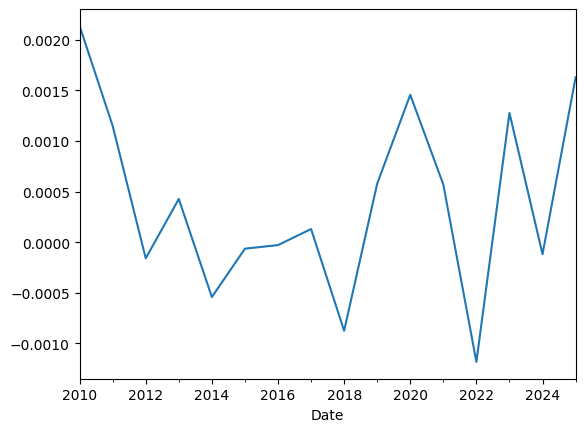

In [49]:
yearly_sampled_mean = returns.resample('Y').mean()
yearly_sampled_mean.plot();

C:\Users\USER\AppData\Local\Temp\ipykernel_17268\3459962991.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_sampled_std = returns.resample('Y').std()


<Axes: xlabel='Date'>

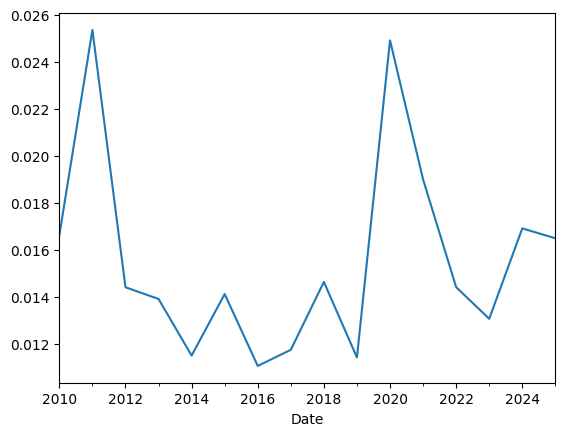

In [46]:
yearly_sampled_std = returns.resample('Y').std()
yearly_sampled_std.plot()

<Axes: xlabel='Date'>

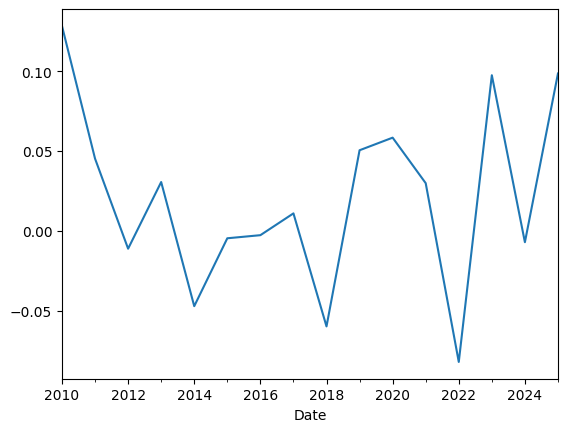

In [50]:
sharpe_ratio = yearly_sampled_mean/yearly_sampled_std
sharpe_ratio.plot()

In [110]:
def Normal_test(returns,year):
    
    _, p_value, skewness, kurtosis = jarque_bera(returns)
    # print("The JB test p-value is: ", p_value) 
    # print("The skewness of the returns is: ", skewness) 
    # print("The kurtosis of the returns is: ", kurtosis)

    df , mu, std = stats.t.fit(returns)
    sharpe_ratio = mu/std

    # print("자유도: ",df)
    # print("평균: ",mu)
    # print("표준편차: ",std)

    # 1. 99% VaR 계산 (하위 1% 지점 찾기)
    # ppf(0.01, ...) -> 왼쪽 꼬리 1% 지점의 수익률을 반환
    var_99 = stats.t.ppf(0.01, df, mu, std)

    # 2. 95% VaR 계산 (하위 5% 지점 찾기)
    var_95 = stats.t.ppf(0.05, df, mu, std)

    # print(f"99% VaR (최악의 경우): {var_99:.4f} ({var_99*100:.2f}%)")
    # print(f"95% VaR (통상적 위기): {var_95:.4f} ({var_95*100:.2f}%)")

    crash_days = returns[returns <= var_95].index
    if len(crash_days) > 2:
        intervals = pd.Series(crash_days).diff().dt.days.dropna() # X 데이터 완성

        _, scale = stats.expon.fit(intervals, floc=0)

        days_to_check = 5
        prob_recurrence = stats.expon.cdf(days_to_check, scale=scale).round(3)

        # print(f"--- 분석 결과 ---")
        # print(f"1. 평균 간격 (Scale): 약 {scale:.1f}일마다 한 번씩 터짐")
        # print(f"2. 연쇄 위험 확률: 한 번 폭락 후 {days_to_check}일 안에 또 폭락할 확률은 {prob_recurrence*100:.2f}% 입니다.")
        
        return {
            "Year": year,
            "p_value":p_value,
            "자유도":df,
            "Sharpe":sharpe_ratio,
            "VaR_99":var_99,
            "VaR_95":var_95,
            "5일안에 폭락할 확률":prob_recurrence*100 
        }

In [116]:
results_list = []

for year, data in returns.groupby(returns.index.year):
    res = Normal_test(data,year)
    if res:
        results_list.append(res)

result_df = pd.DataFrame(results_list)
result_df.set_index("Year", inplace=True)

result_df.to_csv("KODEX_Car_ETF.csv",encoding='cp949')